In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
import matplotlib.dates as mdates
import ipywidgets as widgets

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.4f' % x)

A equação (1) é conhecida como Vetores autoregressivos aumentado por Fatores, FAVAR

$$
\begin{bmatrix}
F_t \\
Y_t 
\end{bmatrix}
= \Phi(L)
\begin{bmatrix}
F_{t-1} \\
Y_{t-1}
\end{bmatrix}
+ V_t
$$

Onde: 
$F_t$ é um vetor de fatores não observados, 
$Y_t$ é um vetor de variáveis observadas, 
$\Phi(L)$ é uma matriz de polinômios de defasagem,
$V_t$ é um vetor de resíduos. 

O vetor $Y_t$ contém $M$ variáveis econômicas observáveis.
O vetor $F_t$ contém $K$ fatores não observados que supostamente influenciam as variáveis econômicas;

In [2]:
df = pd.read_excel("bbedata.xlsx",index_col=0, parse_dates=True)
df.index = df.index.strftime('%m/%Y')

In [3]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [4]:
slow_variables = df[["IP", "LHUR", "PUNEW", "IPP", "IPF", "IPC", "IPCD", "IPCN", "IPE", "IPI", "IPM",
                  "IPMD", "IPMND", "IPMFG", "IPD", "IPN", "IPMIN", "IPUT", "IPXMCA", "PMI", "PMP",
                  "GMPYQ", "GMYXPQ", "LHEL", "LHELX", "LHEM", "LHNAG", "LHU680", "LHU5", "LHU14",
                  "LHU15", "LHU26", "LPNAG", "LP", "LPGD", "LPMI", "LPCC", "LPEM", "LPED", "LPEN",
                  "LPSP", "LPTU", "LPT", "LPFR", "LPS", "LPGOV", "LPHRM", "LPMOSA", "PMEMP", "GMCQ",
                  "GMCDQ", "GMCNQ", "GMCSQ", "GMCANQ", "PWFSA", "PWFCSA", "PWIMSA", "PWCMSA", "PSM99Q",
                  "PU83", "PU84", "PU85", "PUC", "PUCD", "PUS", "PUXF", "PUXHS", "PUXM", "LEHCC", "LEHM"]]

O método PCA requer dados normalizados, com média zero e desvio padrão unitário.

Utiliza-se o Scaler para normalizar os dados e o PCA para reduzir a dimensionalidade dos dados.

$$
Z = \frac{(X - U)}{S}
$$

Onde:
$Z$ é o valor normalizado,
$X$ é o valor original,
$U$ é a média dos valores originais,
$S$ é o desvio padrão dos valores originais.


In [5]:
scaler.fit(slow_variables)
scaled_slow_data = scaler.transform(slow_variables)

In [6]:
#dataframe of scaled data
data_s = pd.DataFrame(scaled_data)
data_s.columns = df.columns
data_s.index = df.index

FYFF = data_s["FYFF"].reset_index(drop=True)

In [7]:
# PCA on entire dataset is C
pca = PCA(n_components=3)

C = pd.DataFrame(pca.fit_transform(scaled_data))

# rename columns to PC1, PC2, PC3
C.columns = ["PC1", "PC2", "PC3"]
C["PC3"] = C["PC3"] * - 1

In [8]:
F_slow = pd.DataFrame(pca.fit_transform(scaled_slow_data))
F_slow.columns = ["F1", "F2", "F3"]

F_slow["FYFF"] = FYFF

# merge C and df2
F_slow = pd.concat([C, F_slow], axis=1)

A Equação (1) não pode ser estimada diretamente uma vez que os fatores $\( F_t \)$ são inobserváveis e devem ser substituídos por $\( \hat{F}_t \)$.
Os fatores estimados, $\( \hat{F}_t \)$, são assumidos baseados em um número de séries temporais que coletivamente são denotadas pelo vetor $\( N \times 1 \) \( X_t \)$.
Qualquer economia desenvolvida envolve muitas atividades diferentes que podem ser descritas por várias séries temporais.
Assim, o número de séries temporais $\( N \)$ em $\( X_t \)$ é considerado grande, e pode ser bem maior que $\( T \)$, o número de períodos de tempo.
Bernanke et al. (2005) assumem que as séries temporais em $\( X_t \)$ estão relacionadas aos fatores inobserváveis $\( F_t \)$ e às variáveis econômicas observáveis $\( Y_t \)$ por uma equação dada por

$$
\[
    X_t = \Lambda F_t + \Lambda^Y Y_t + e_t
\]
$$
Onde $\( \Lambda \)$ é uma matriz $\( N \times K \)$ de fatores carregados,
$\( \Lambda^Y \)$ tem dimensão $\( N \times M \)$
$\( e_t \)$ é $\( N \times 1 \)$ um vetor de erros com média zero.

A equação (2) expressa a ideia de que tanto $\( Y_t \)$ como $\( F_t \)$, que podem ser correlacionados, expressão as relações contidas em $\( X_t \)$.

In [9]:
Factor = pd.DataFrame()

def perform_ols_and_update_factor(dependent_var):
    y = C[[dependent_var]]
    x = F_slow[["FYFF", "F1", "F2", "F3"]]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    f_hat = C - np.dot(data_s["FYFF"].values.reshape(-1, 1), model.params[1])
    Factor[dependent_var] = f_hat[dependent_var]

In [10]:
# Call the function for each dependent variable
perform_ols_and_update_factor("PC1")
perform_ols_and_update_factor("PC2")
perform_ols_and_update_factor("PC3")

Factor["FYFF"] = data_s["FYFF"].reset_index(drop=True)
df_var = Factor

In [11]:
f_hat = Factor[["PC1", "PC2", "PC3","FYFF"]].values
loadings = pd.DataFrame(np.linalg.lstsq(f_hat, data_s, rcond=None)[0])
loadings.columns = df.columns
loadings.index = ["PC1", "PC2", "PC3","FYFF"]

In [12]:
reg_loadings = np.linalg.lstsq(f_hat, data_s, rcond=None)

# get fitted values
fitted_values = np.dot(f_hat, reg_loadings[0])
fitted_values = pd.DataFrame(fitted_values)
fitted_values.columns = data_s.columns

Inclusão dos Fatores no VAR: 
Uma vez estimados, esses fatores são incluídos como variáveis adicionais no modelo VAR, 
permitindo que o modelo capture as dinâmicas mais amplas da economia que não seriam capturadas apenas pelas variáveis observáveis.

A equação (1) do modelo FAVAR, agora com os fatores devidamente estimados pode ser expressa pela equação (3):

$$
\begin{bmatrix}
\( \hat{F}_t \)\\
Y_t 
\end{bmatrix}
= \Phi(L)
\begin{bmatrix}
\( \hat{F}_{t-1} \) \\
Y_{t-1}
\end{bmatrix}
+ V_t
$$

Onde: 
$\hat{F}_t$ é um vetor de fatores estimados pela equação (2), 
$Y_t$ é um vetor de variáveis observadas, 
$\Phi(L)$ é uma matriz de polinômios de defasagem,
$V_t$ é um vetor de resíduos. 

O vetor $Y_t$ contém $M$ variáveis econômicas observáveis.
O vetor $\hat{F}_t$ contém $K$ fatores estimados a partir das séries temporais que influenciam a economia;


In [13]:
# O modelo FAVAR estimado é dado por:

model = VAR(df_var)
results = model.fit(13, trend="c")
resid = results.resid
params = results.params
lag_order = results.k_ar

orth_irf = results.irf(48).orth_irfs
irf_fyff = orth_irf[:, :, results.names.index('FYFF')]
irf_fyff = pd.DataFrame(irf_fyff)
irf_fyff.index = range(0, 49)

# Calculando o desvio padrão do impulso e escalando o IRF
impulse_sd = 0.25 / df['FYFF'].std()
scale = impulse_sd / irf_fyff[3].iloc[0]

irf_line = np.dot(irf_fyff, loadings.iloc[:4]) * scale

In [14]:
R = 500 # Número de simulações de bootstrap
nvars = len(data_s.columns) # Número de variáveis no modelo
nsteps = 49 # Número Períodos no IRF

IRFs = np.zeros((nsteps, nvars, R))
Upper = np.zeros((nsteps, nvars))
Lower = np.zeros((nsteps, nvars))
const_in_model = 'const' in results.exog_names

# Precompute as much as possible outside the loop
lagged_data = np.hstack([df_var.shift(lag).values[lag_order:] for lag in range(1, lag_order + 1)])

# This part assumes parallel processing or similar optimization is applied, still needs some work
for j in range(R):
    resampled_resid = resid.sample(n=len(resid), replace=True, random_state=j).reset_index(drop=True)
    data_boot = df_var.copy()

    for i in range(lag_order, len(df_var)):
        lagged_values = np.concatenate([data_boot.iloc[i - lag].values for lag in range(1, lag_order + 1)])

        if const_in_model:
            lagged_values = np.insert(lagged_values, 0, 1)

        predicted_value = np.dot(lagged_values, results.params) + resampled_resid.iloc[i - lag_order]
        data_boot.iloc[i] = predicted_value

    model_boot = VAR(data_boot)
    results_boot = model_boot.fit(13, trend='c')

    irf_res = results_boot.irf(48).orth_irfs
    for i in range(nvars):
        irf_transformed = np.dot(irf_res[:, :, results_boot.names.index('FYFF')], loadings.iloc[:4, i]) * scale
        IRFs[:, i, j] = irf_transformed[:nsteps]

for k in range(nsteps):
    for i in range(nvars):
        Upper[k, i] = np.quantile(IRFs[k, i, :], 0.95) # intervalo de confiança de 95%
        Lower[k, i] = np.quantile(IRFs[k, i, :], 0.05) # intervalo de confiança de 5%

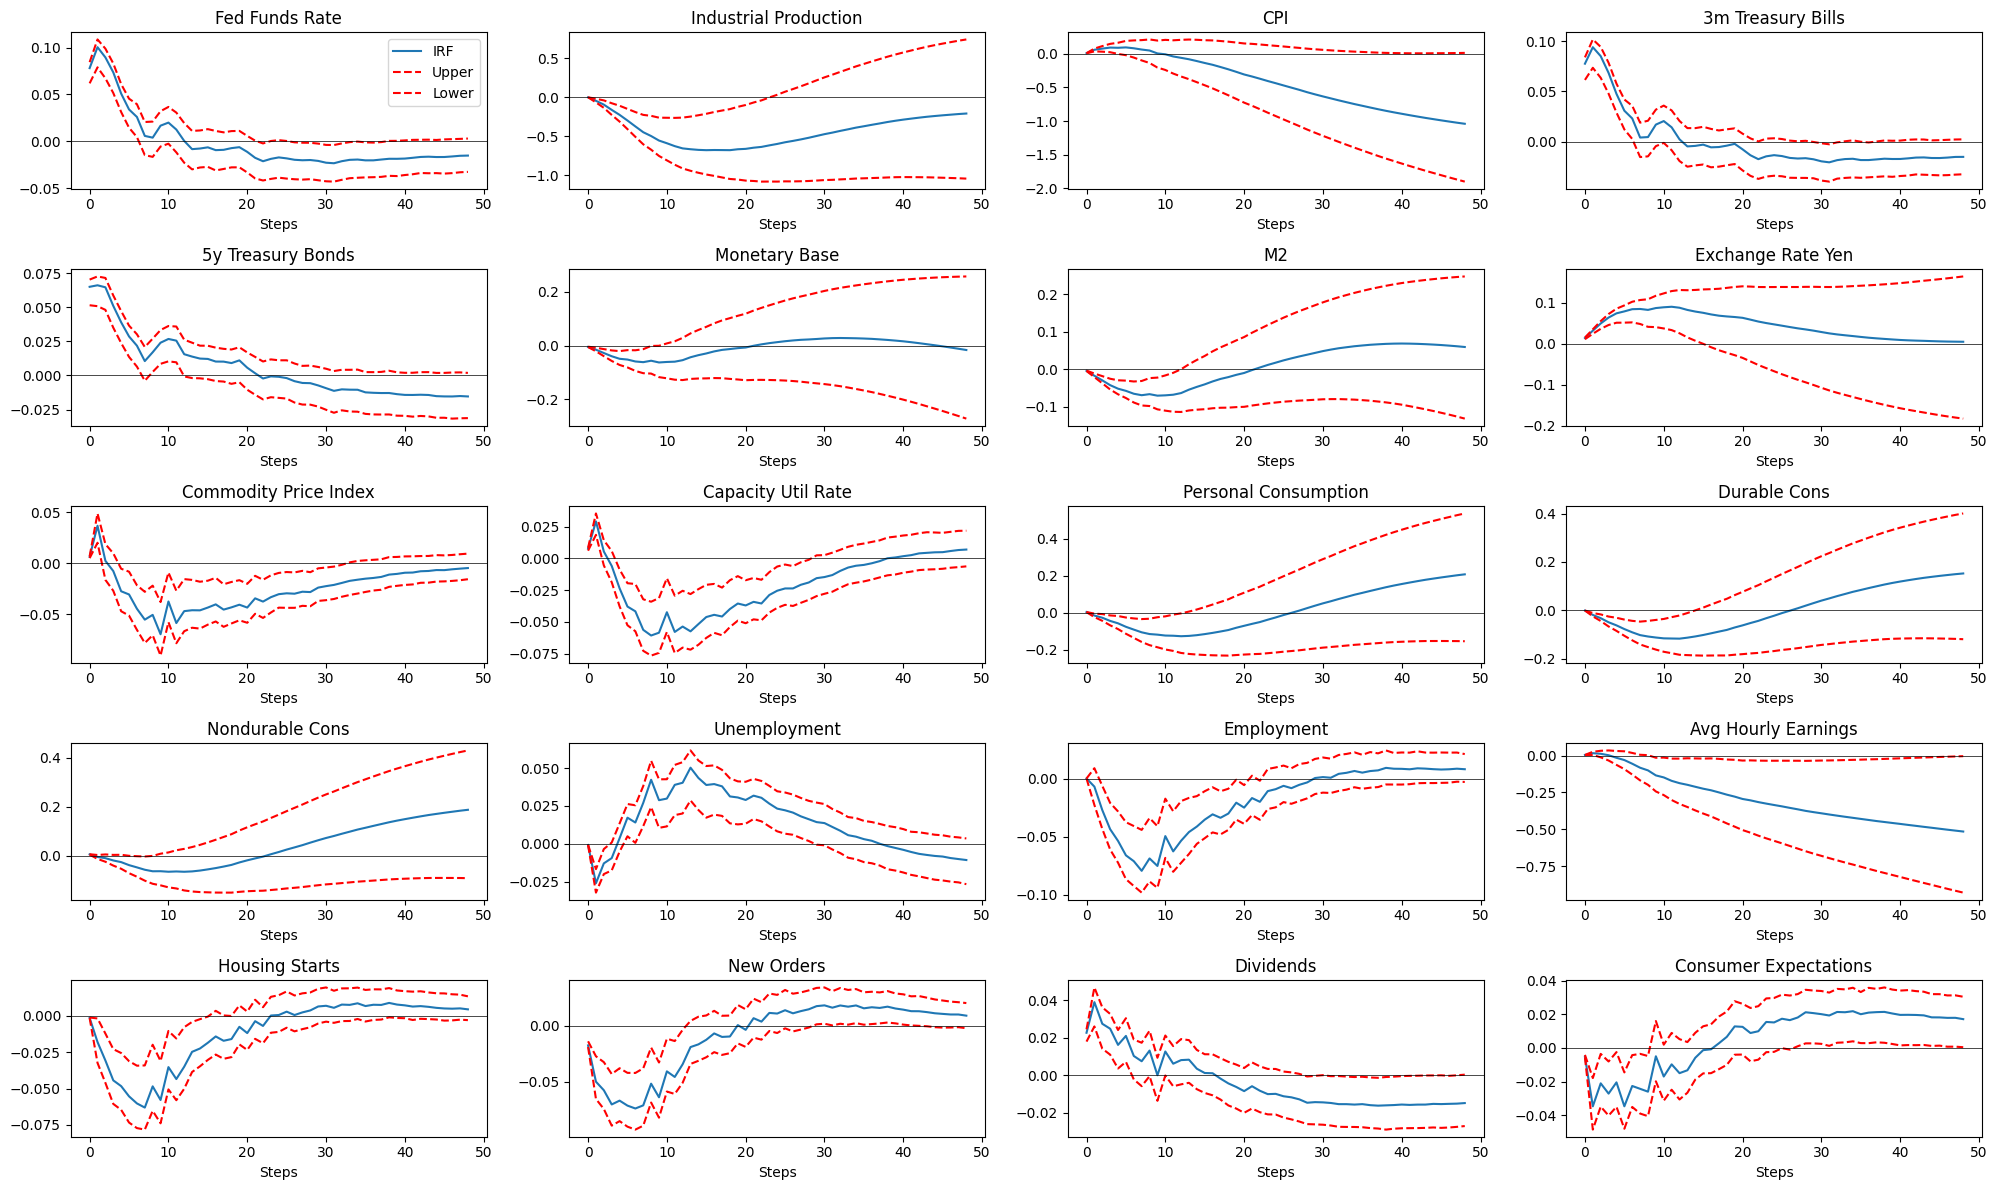

In [15]:
# Plotando os IRFs com base nas de maior impacto

variables = ["FYFF", "IP", "PUNEW", "FYGM3", "FYGT5", "FMFBA", 
             "FM2", "EXRJAN", "PMCP", "IPXMCA", "GMCQ", "GMCDQ", 
             "GMCNQ", "LHUR", "PMEMP", "LEHM", "HSFR", "PMNO", "FSDXP", "HHSNTN"]

transf_code = [1, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 1, 1, 1]

variable_names = ["Fed Funds Rate", "Industrial Production", "CPI", "3m Treasury Bills",
                  "5y Treasury Bonds", "Monetary Base", "M2", "Exchange Rate Yen", 
                  "Commodity Price Index", "Capacity Util Rate", "Personal Consumption", 
                  "Durable Cons", "Nondurable Cons", "Unemployment", "Employment", 
                  "Avg Hourly Earnings", "Housing Starts", "New Orders", "Dividends", "Consumer Expectations"]

# Create a 5x4 grid of subplots and set the figure size in pixels
fig, axs = plt.subplots(5, 4, figsize=(20, 12))

fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Iterate over each variable
for i, var in enumerate(variables):
    # Get the index of the variable in the dataframe
    index = data_s.columns.get_loc(var)

    # Get the subplot axes
    ax = axs[i // 4, i % 4]

    # Plot the IRF, cumulative sum if transf_code is 5
    if transf_code[i] == 5:
        ax.plot(irf_line[:, index].cumsum(), label='IRF')
        ax.plot(Upper[:, index].cumsum(), label='Upper', linestyle='--', color='red')
        ax.plot(Lower[:, index].cumsum(), label='Lower', linestyle='--', color='red')
    else:
        ax.plot(irf_line[:, index], label='IRF')
        ax.plot(Upper[:, index], label='Upper', linestyle='--', color='red')
        ax.plot(Lower[:, index], label='Lower', linestyle='--', color='red')

    # Set the title and labels
    ax.set_title(variable_names[i])
    ax.set_xlabel('Steps')
    ax.set_ylabel('')

    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linewidth=0.5)

# Add a legend
axs[0, 0].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#save fig as png, by removing the comment
#fig.savefig('IRF_FAVAR.png', dpi=600)

Quanto da variação é capturado pelos fatores e pelo FYFF?

In [27]:
def plot_variable(var):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(data_s.index, data_s[var], label=var, color='blue', linestyle='dashed')
    ax.plot(data_s.index, fitted_values[var], label=f"Fitted {var}", color='red', linestyle='solid')

    plt.xticks(rotation=45)
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig.autofmt_xdate()
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming data_s is your DataFrame and it has several columns you want to be able to choose from
variables = list(data_s.columns)  # Lista de Variáveis
variables.sort()
dropdown = widgets.Dropdown(options=variables, value=variables[0], description='Variable:')

# Use the interact function to create the interaction between the widget and the plot function
widgets.interact(plot_variable, var=dropdown)

interactive(children=(Dropdown(description='Variable:', options=('CCINRV', 'EXRCAN', 'EXRJAN', 'EXRSW', 'EXRUK…

<function __main__.plot_variable(var)>

In [28]:
# Get the IRF for 'hor' periods ahead without bootstrapping
hor = 60

orth_irf = results.irf(hor).orth_irfs

# Initialize dictionaries to hold the IRFs
irf_arrays = {
    'irf_X_pc1': np.zeros((hor+1, len(variables))),
    'irf_X_pc2': np.zeros((hor+1, len(variables))),
    'irf_X_pc3': np.zeros((hor+1, len(variables))),
    'irf_X_fyff': np.zeros((hor+1, len(variables)))
}

# Calculate the IRFs for each variable and loadings
for i, var in enumerate(variables):
    irf_arrays['irf_X_pc1'][:, i] = np.dot(orth_irf[:, :, results.names.index("PC1")], loadings.iloc[:4, data_s.columns.get_loc(var)])
    irf_arrays['irf_X_pc2'][:, i] = np.dot(orth_irf[:, :, results.names.index('PC2')], loadings.iloc[:4, data_s.columns.get_loc(var)])
    irf_arrays['irf_X_pc3'][:, i] = np.dot(orth_irf[:, :, results.names.index('PC3')], loadings.iloc[:4, data_s.columns.get_loc(var)])
    irf_arrays['irf_X_fyff'][:, i] = np.dot(orth_irf[:, :, results.names.index('FYFF')], loadings.iloc[:4, data_s.columns.get_loc(var)])

In [29]:
coefficients, residuals, rank, s = np.linalg.lstsq(f_hat, data_s, rcond=None)

# Number of observations (n) and number of predictors (k)
n = data_s.shape[0]
k = f_hat.shape[1] - 1 

# Subtracting 1 because we don't count the constant/intercept
RSE = np.zeros(len(residuals))
    
for i in range(len(residuals)):
    if residuals.size == 0:
        RSE[i] = 0
    else:
        RSE[i] = np.sqrt(residuals[i] / (n - k - 1))
        
#set RSE index as data_s columns
RSE = pd.DataFrame(RSE)
RSE.index = data_s.columns

In [33]:
# Calculate predicted values
predicted_values = f_hat.dot(coefficients)

# Calculate individual residuals
individual_residuals = data_s - predicted_values

# Calculate SSR (Sum of Squares of Residuals)
SSR = np.sum(individual_residuals**2, axis=0)

# Calculate SST (Total Sum of Squares)
mean_data_s = np.mean(data_s, axis=0)
SST = np.sum((data_s - mean_data_s)**2, axis=0)

# Calculate R-squared for each regression
R_squared = 1 - (SSR / SST)

R_squared = pd.DataFrame(R_squared)
R_squared.rename(columns={0: 'R-squared'}, inplace=True) 
R_squared.head(20)

,R-squared
IPP,0.6576
IPF,0.5619
IPC,0.3948
IPCD,0.3641
IPCN,0.1274
IPE,0.4661
IPI,0.4812
IPM,0.5565
IPMD,0.5340
IPMND,0.1641


In [34]:
# Initialize arrays to store squared IRFs
hor = 60
key_nvars = len(variables)

psi2_pc1 = np.zeros(key_nvars)
psi2_pc2 = np.zeros(key_nvars)
psi2_pc3 = np.zeros(key_nvars)
psi2_fyff = np.zeros(key_nvars)

# Accumulate squared IRFs
for i in range(key_nvars):  # Python is 0-indexed
    for j in range(hor):
        psi2_pc1[i] += irf_arrays["irf_X_pc1"][j, i]**2
        psi2_pc2[i] += irf_arrays["irf_X_pc2"][j, i]**2
        psi2_pc3[i] += irf_arrays["irf_X_pc3"][j, i]**2
        psi2_fyff[i] += irf_arrays["irf_X_fyff"][j, i]**2

In [35]:
# Initialize arrays for total variance and variance from factors
var_total = np.zeros(key_nvars)
var_fac = np.zeros(key_nvars)
var_e = np.zeros(key_nvars)

# Calculate variances
for i, var_name in enumerate(variables):
    var_fac[i] = psi2_pc1[i] + psi2_pc2[i] + psi2_pc3[i] + psi2_fyff[i]

    # Ensure you are accessing the RSE value for the current variable
    rse_value = RSE.loc[var_name] ** 2  # This will get the RSE value for the specific variable

    var_total[i] = var_fac[i] + rse_value
    var_e[i] = rse_value

In [38]:
#group psi2_pc1, psi2_pc2, psi2_pc3 and psi2_fyff in a dataframe
irf_squared = pd.DataFrame({'psi2_pc1': psi2_pc1, 'psi2_pc2': psi2_pc2, 'psi2_pc3': psi2_pc3, 'psi2_fyff': psi2_fyff}, index=variables)
irf_squared["var_e"] = var_e
irf_squared["var_fac"] = var_fac
irf_squared["var_total"] = var_total

#round columns to 4 decimal places
irf_squared = irf_squared.round(3)
irf_squared.head(5)

,psi2_pc1,psi2_pc2,psi2_pc3,psi2_fyff,var_e,var_fac,var_total
CCINRV,0.1490,0.0100,0.0110,0.0410,0.8080,0.2110,1.0190
EXRCAN,0.0080,0.0020,0.0020,0.0020,0.9920,0.0140,1.0060
EXRJAN,0.0160,0.0030,0.0050,0.0050,0.9830,0.0280,1.0120
EXRSW,0.0110,0.0060,0.0010,0.0020,0.9850,0.0200,1.0050
EXRUK,0.0100,0.0060,0.0000,0.0020,0.9820,0.0180,1.0000


In [39]:
#group var_fac, var_e and var_total in a dataframe
variance_decomposition = pd.DataFrame({'var_fac': var_fac, 'var_e': var_e, 'var_total': var_total}, index=variables)
variance_decomposition.head(5)

,var_fac,var_e,var_total
CCINRV,0.2110,0.8080,1.0191
EXRCAN,0.0143,0.9915,1.0058
EXRJAN,0.0284,0.9832,1.0116
EXRSW,0.0200,0.9854,1.0053
EXRUK,0.0180,0.9817,0.9997


In [42]:
contribution = irf_squared[["psi2_fyff"]].div(irf_squared["var_total"], axis=0)
contribution = contribution.round(3)
contribution["R-squared"] = R_squared
contribution

,psi2_fyff,R-squared
CCINRV,0.0400,0.1983
EXRCAN,0.0020,0.0163
EXRJAN,0.0050,0.0245
EXRSW,0.0020,0.0224
EXRUK,0.0020,0.0260
...,...,...
SFYGM3,0.1380,0.7274
SFYGM6,0.1440,0.7409
SFYGT1,0.1320,0.6031
SFYGT10,0.1730,0.8342
